In [1]:
import os
import cv2
import torch
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
import albumentations
import matplotlib.pyplot as plt
import torch.nn as nn


from tqdm import tqdm
from utils import load_obj, save_obj
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
class CRNN_data255(nn.Module):

    def __init__(self, n_classes): # n_classes: number of unique characters in the dataset
        
        super(CRNN_data255, self).__init__()

        self.relu = nn.LeakyReLU(0.2, inplace=True)

        self.conv_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn_1 = nn.BatchNorm2d(64)
        self.pool_1 = nn.MaxPool2d((2, 2))

        self.conv_2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn_2 = nn.BatchNorm2d(128)
        self.pool_2 = nn.MaxPool2d((2, 2))

        self.conv_3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn_3 = nn.BatchNorm2d(256)

        self.conv_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn_4 = nn.BatchNorm2d(256)
        self.pool_4 = nn.MaxPool2d((2, 1))

        self.conv_5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn_5 = nn.BatchNorm2d(512)

        self.conv_6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn_6 = nn.BatchNorm2d(512)
        self.pool_6 = nn.MaxPool2d((2, 1))

        self.conv_7 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn_7 = nn.BatchNorm2d(512)

        self.linear_1 = nn.Linear(1024, 64)
        self.linear_2 = nn.Linear(64, 64)

        self.rnn_1 = nn.GRU(64, 128, num_layers=2,
                            bidirectional=True,
                            dropout=0.25,
                            batch_first=True)
        self.rnn_2 = nn.GRU(256, 64, num_layers=2,
                            bidirectional=True,
                            dropout=0.25,
                            batch_first=True)

        self.dense = nn.Linear(128, n_classes + 1)

    def forward(self, images):
        x = self.conv_1(images)
        x = self.bn_1(x)
        x = self.relu(x)
        x = self.pool_1(x)

        x = self.conv_2(x)
        x = self.bn_2(x)
        x = self.relu(x)
        x = self.pool_2(x)

        x = self.conv_3(x)
        x = self.bn_3(x)
        x = self.relu(x)

        x = self.conv_4(x)
        x = self.bn_4(x)
        x = self.relu(x)
        x = self.pool_4(x)

        x = self.conv_5(x)
        x = self.bn_5(x)
        x = self.relu(x)

        x = self.conv_6(x)
        x = self.bn_6(x)
        x = self.relu(x)
        x = self.pool_6(x)

        x = self.conv_7(x)
        x = self.bn_7(x)
        x = self.relu(x)

        x = x.view(-1, 512 * 2, 40)
        x = x.permute(0, 2, 1)

        x = self.linear_1(x)
        x = self.relu(x)

        x = self.linear_2(x)
        x = self.relu(x)

        x, _ = self.rnn_1(x)
        x, _ = self.rnn_2(x)

        x = self.dense(x)
        return x


In [3]:


class get_data(torch.utils.data.Dataset):

    def __init__(self, data_file, char2int): # data_file: pandas dataframe containing the image path and labels, 
    
        self.image_ids = list(data_file["images"])
        self.labels = list(data_file["labels"])
        self.char2int = char2int
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
        self.aug = albumentations.Compose(
            [albumentations.Normalize(mean, std,
                                      max_pixel_value=255.0,
                                      always_apply=True)]
        )
        self.max_len = data_file["labels"].apply(lambda x: len(x)).max()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # Get image id
        img_id = self.image_ids[idx]
        # Load the image
        img = cv2.imread(img_id)
        # Normalize the image
        augmented = self.aug(image=img)
        img = augmented['image']
        # Bring channel first
        img = img.transpose(2, 0, 1)
        # Convert to torch tensor
        img = torch.from_numpy(img)

        # Get the labels
        target = self.labels[idx]
        # Convert characters to integers
        target = [self.char2int[i] for i in target]
        # Length of each target
        target_len = torch.LongTensor([len(target)])
        # Pad target with zeros to make sure every
        # target has equal length
        target += [0] * (self.max_len - len(target))
        # Convert to torch tensor
        target = torch.LongTensor(target)

        return img, target, target_len


In [4]:


def train(model, dataloader, criterion, device, optimizer=None, test=False):

    if test:
        model.eval()
    else:
        model.train()
    loss = []
    for inp, tgt, tgt_len in tqdm(dataloader):
        inp = inp.to(device)
        tgt = tgt.to(device)
        target_len = tgt_len.to(device)
        # Forward pass
        out = model(inp)
        out = out.permute(1,0,2)
        # Calculate input lengths for the data points
        # All have equal length of 40 since all images in
        # our dataset are of equal length
        input_len = torch.LongTensor([40] * out.shape[1])
        # Calculate CTC Loss
        log_probs = nn.functional.log_softmax(out, 2)
        loss_ = criterion(log_probs, tgt, input_len, target_len)

        if not test:
            # Update weights during training
            optimizer.zero_grad()
            loss_.backward()
            optimizer.step()

        loss.append(loss_.item())

    return np.mean(loss)


In [5]:
epochs = 15
batch_size = 32
model_path = "data_255/models/model.pth"
char2int_path = "data_255/data/char2int.pkl"
int2char_path = "data_255/data/int2char.pkl"
data_file_path = "data_255/data/data_file.csv"
image_path = "data_255/images"
label_path = "data_255/labels.txt"

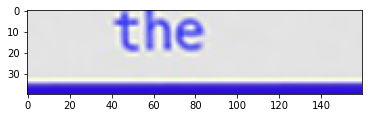

In [6]:
img = plt.imread(os.path.join(image_path,"00000017.jpg"))
plt.imshow(img)
plt.show()

In [7]:
labels = pd.read_table(label_path, header=None)

In [8]:
labels.head()

,0
0,life
1,not
2,while
3,know
4,clearly


In [9]:
labels.iloc[17,0]

'the'

In [10]:
labels.shape

(100000, 1)

### Total number of images

In [11]:
def total_images(image_path):
    return len(os.listdir(image_path))


In [12]:
total_images(image_path)

100010

In [13]:
# len(os.listdir(image_path))

### Find null values in labels

In [14]:
def check_null():
    print(labels.isna().sum())
    print(" ")
    print("Image id with null values")
    print(labels[labels[0].isna()])

In [15]:
check_null()

0    2
dtype: int64
 
Image id with null values
         0
19198  NaN
74347  NaN


In [16]:

# labels.isna().sum()

In [17]:
# labels[labels[0].isna()]

### Let's check those images

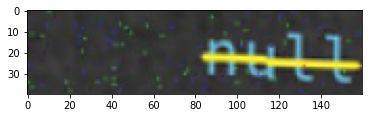

In [18]:
img = plt.imread(os.path.join(image_path, "00019198.jpg"))
plt.imshow(img)
plt.show()

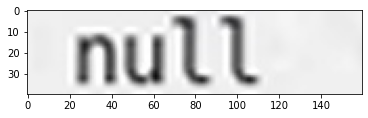

In [19]:
img = plt.imread(os.path.join(image_path, "00074347.jpg"))
plt.imshow(img)
plt.show()

### Replace those missing values with the string "null"

In [20]:
labels.fillna("null", inplace=True)

### Create a dataframe with image paths and corresponding labels

In [21]:
input_image = os.listdir(image_path)
input_image.sort()
input_image = [os.path.join(image_path, i) for i in input_image]

In [22]:
input_file = pd.DataFrame({"images": data_file_path, "labels": labels[0]})
input_file.to_csv(data_file_path, index=False)

In [23]:
input_file.head()

,images,labels
0,data_255/data/data_file.csv,life
1,data_255/data/data_file.csv,not
2,data_255/data/data_file.csv,while
3,data_255/data/data_file.csv,know
4,data_255/data/data_file.csv,clearly


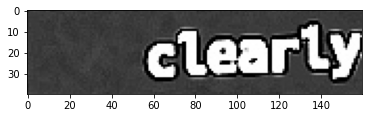

In [24]:
img = plt.imread(os.path.join(image_path, "00000004.jpg"))
plt.imshow(img)
plt.show()

### Find the unique characters in the labels

In [25]:
uniq_chars = list({l for word in labels[0] for l in word})
uniq_chars.sort()

In [26]:
uniq_chars

['#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [27]:
len(uniq_chars)

81

### Create mapping from characters to integer and integer to character and save them to disc

In [28]:
char_to_int = {a: i+1 for i, a in enumerate(uniq_chars)}
int_to_char = {i+1: a for i, a in enumerate(uniq_chars)}

In [29]:
save_obj(char_to_int, char2int_path)
save_obj(int_to_char, int2char_path)

# Training the model

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() 
                      else "cpu")

### Split the data into train and validation

In [31]:
train_file, valid_file = train_test_split(input_file, test_size=0.2)

### Create train and validation datasets

In [32]:
train_dataset = get_data(train_file, char_to_int)
valid_dataset = get_data(valid_file, char_to_int)

### Define the loss function

In [33]:
criterion = nn.CTCLoss(reduction="sum")
criterion.to(device)

CTCLoss()

### Number of classes

In [34]:
n_classes = len(char_to_int)

### Create the model object

In [35]:
model = CRNN_data255(n_classes)
model.to(device)

CRNN_data255(
  (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_4): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), pa

### Define Optimizer

In [36]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005)

### Define train and validation data loaders

In [37]:
train_data = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)

valid_data = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           drop_last=False)

### Training loop

In [38]:
# for i in range(epochs):
#     print(f"Epoch {i+1} of {epochs}...")
#     # Run train function
#     train_loss = train(model, train_data, criterion, device, optimizer, test=False)
#     # Run validation function
#     valid_loss = train(model, valid_data, criterion, device, test=True)
#     print(f"Train Loss: {round(train_loss,4)}, Valid Loss: {round(valid_loss,4)}")
# #     if valid_loss < best_loss:
# #         print("Validation Loss improved, saving Model File...")
# #         # Save model object
# #         torch.save(model.state_dict(), model_path)
# #         best_loss = valid_loss

### Loading trained model & Setting model mode to evaluation

In [39]:
model = CRNN_data255(n_classes)
model.load_state_dict(torch.load(model_path, 
                                map_location=torch.device('cpu')))

# Set model mode to evaluation
model.eval()

CRNN_data255(
  (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_4): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), pa

# Prediction

In [40]:
test_img = os.path.join(image_path, "00000007.jpg")
img = cv2.imread(test_img)

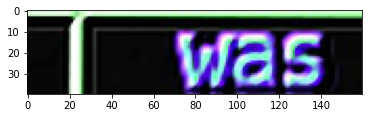

In [41]:
plt.imshow(plt.imread(test_img))
plt.show()

### Apply augmentations

In [42]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
img_aug = albumentations.Compose(
        [albumentations.Normalize(mean, std,
                                  max_pixel_value=255.0,
                                  always_apply=True)]
    )
aug = img_aug(image=img)
img = aug["image"]
img = img.transpose(2, 0, 1)
img = torch.from_numpy(img)
# Create batch dimension (batch of single image)
img = torch.unsqueeze(img, 0)
# Move the image array to CUDA if available
img = img.to(device)

### Take model output

In [43]:
out = model(img)

### Apply softmax and take label predictions

In [44]:
out = torch.squeeze(out, 0)
out = out.softmax(1)
pred = torch.argmax(out, 1)

In [45]:
pred.shape

torch.Size([40])

In [46]:
pred = pred.tolist()

In [47]:
pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 78,
 78,
 0,
 0,
 0,
 0,
 56,
 56,
 0,
 0,
 0,
 0,
 0,
 74,
 0,
 0,
 0,
 0,
 0]

In [48]:
int_to_char[75]

't'

In [49]:
int_to_char[0] = "jsp"

### Convert integer predictions to string

In [50]:
output = [int_to_char[i] for i in pred]

In [51]:
output

['jsp',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 'w',
 'w',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 'a',
 'a',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 's',
 'jsp',
 'jsp',
 'jsp',
 'jsp',
 'jsp']

### Collapse the output

In [52]:
def result():
    result = list()
    result.append(output[0])
    for i in range(1, len(output)):
        if output[i] != output[i - 1]:
            result.append(output[i])
    result = [i for i in result if i != "jsp"]
    result = "".join(result)
    return result

In [55]:
result= result()
print(result)

was


In [56]:
import fastwer
l = ['was'] # for testing purpose we have changed it manually
r = [str(result)]
# Corpus-Level WER
print(fastwer.score(l, r))
# Corpus-Level CER
fastwer.score(l, r, char_level=True)

0.0


0.0